In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
import ast
import re

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

In [4]:
file_name=[f for f in os.listdir(os.getcwd()) if f.endswith('.csv')][0]

df=pd.read_csv(os.path.join(os.getcwd(),file_name))

In [8]:
df.head()

,Gift Idea,Persona,Category,Description,Budget Range,embedding
0,Meta Quest 3,The Tech Enthusiast,Tech,Latest VR headset for immersive gaming and vir...,£225-£375,[-4.72785719e-02 1.27385305e-02 -2.10357774e-...
1,Apple AirPods Pro 2 (USB-C),The Tech Enthusiast,Tech,"High-quality sound and noise cancellation, ide...",£150-£187,[-4.49886806e-02 -1.42445443e-02 3.32742296e-...
2,Galaxy Projector,The Tech Enthusiast,Tech,"Creates a mesmerizing starry night effect, ble...",£37-£75,[-1.01029001e-01 3.62537466e-02 5.54630011e-...
3,Smart Home Assistant,The Tech Enthusiast,Tech,Voice-activated assistant for controlling devi...,£37-£75,[-8.40697885e-02 -1.29552325e-02 4.28833850e-...
4,Portable Phone Charger,The Tech Enthusiast,Tech,Compact power bank to keep devices charged on ...,£15-£37,[-1.11287005e-01 1.39949813e-01 -5.19363619e-...


In [20]:
text=''.join(s for s in df['Gift Idea'])

In [31]:
# Combine custom excluded words with WordCloud's default stopwords
exclude_words = ['Plus', 'Mini']
custom_stopwords = set(STOPWORDS).union(set(exclude_words))

In [33]:
wordcloud=WordCloud(width=800, height=400, background_color='white',stopwords=custom_stopwords).generate(text)

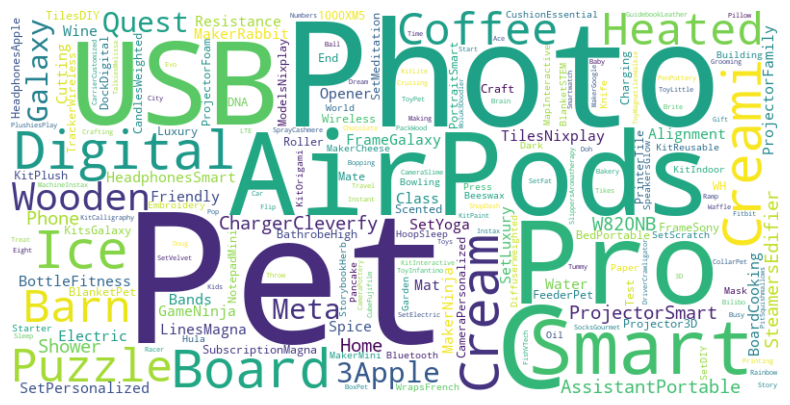

In [35]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Data Preparation for Deep Learning

In [22]:
from transformers import AutoTokenizer,AutoModel
import torch
import streamlit as st

In [42]:
# Load the tokenizer and pre-trained model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model=AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [94]:
#Functions to compute embeddings
def get_embedding(text,tokenizer,model):
    inputs = tokenizer(text,return_tensors='pt',truncation=True,max_length=128,padding='max_length')
    with torch.no_grad(): #no gradient as we are not training model
        outputs=model(**inputs) #output is of shape(batch_size ,sequence_length, embedding_dim) batch_size is 1 for 1 text
    # Average the last hidden state to get sentence embeddings
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.squeeze().numpy() # change the shape to (embedding_dim)

In [ ]:
df['embedding'] = df['Description'].apply(lambda x:get_embedding(x,tokenizer,model))

# Save the embeddings for reuse
df.to_csv('christmas_gift_suggestions_with_embeddings.csv', index=False)


In [8]:
embedding_df=pd.read_csv('christmas_gift_suggestions_with_embeddings.csv')

In [ ]:
# Correct the format by replacing spaces with commas inside the brackets
embedding_df['embedding'] = embedding_df['embedding'].apply(
    lambda x: re.sub(r'(?<=\d)\s+(?=\-?\d)', ',', x.strip())
)

embedding_df['embedding']=embedding_df['embedding'].apply(lambda x: np.array(ast.literal_eval(x)))

embeddings=np.stack(embedding_df['embedding'].values)

In [130]:
print(embeddings.shape)  # Should be (num_samples, embedding_dim)

(70, 384)


In [ ]:
scaler=StandardScaler()

scaled_embeddings=scaler.fit_transform(embeddings)

## Use Sentence Embeddings

In [567]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import joblib

In [390]:
# Load a pre-trained Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and fast model

In [406]:
df['embedding']=df.apply(
lambda row: model.encode(f"{row['Gift Idea']} {row['Description']} for {row['Persona']}"),axis=1
)


In [384]:
df.to_csv("df_with_embeddings.csv", index=False)

In [394]:
joblib.dump(model,"model.pkl")

['model.pkl']

#### Generate User Input Embedding 

In [574]:
# User input description (can be dynamically taken from input in the app)
user_input = "Dad who loves tea"


In [576]:
# Generate embedding for the user input and reshape it to 1 row n columns
user_embedding = model.encode(user_input).reshape(1, -1)

#### Calculate Cosine Similarity

In [410]:
# Convert the 'embedding' column back to a numpy array for similarity calculation
gift_embeddings=np.array(df['embedding'].tolist())

In [450]:
#save gift_embeddings
np.save('gift_embeddings.npy',gift_embeddings)

In [578]:
# Compute cosine similarity between user input and all gift embeddings
similarity_score=cosine_similarity(user_embedding,gift_embeddings)
# Add similarity scores to the dataframe for reference
df['similarity_score'] = similarity_score.flatten()
# Sort the DataFrame based on similarity score in descending order
df_sorted = df.sort_values(by='similarity_score', ascending=False)
# Get the top N recommendations (e.g., top 5)
top_n = 5
top_recommendations = df_sorted.head(top_n)


In [444]:
# Display top N recommendations
print(top_recommendations[['Gift Idea', 'Persona', 'similarity_score']])


                                     Gift Idea          Persona  \
47                          Indoor Bowling Set  The Busy Parent   
52                   French Press Coffee Maker       The Foodie   
13                  Family-Friendly Board Game  The Busy Parent   
87  Pottery Barn Coffee And Bakery Wooden Shop             Kids   
45                    Glow-in-the-Dark Blanket  The Busy Parent   

    similarity_score  
47          0.307989  
52          0.289391  
13          0.276610  
87          0.270036  
45          0.256101  


In [448]:
df.head()

,Gift Idea,Persona,Category,Description,Budget Range,embedding,similarity_score
0,Meta Quest 3,The Tech Enthusiast,Tech,Latest VR headset for immersive gaming and vir...,£225-£375,"[-0.047278572, 0.0127385305, -0.021035777, -0....",0.040603
1,Apple AirPods Pro 2 (USB-C),The Tech Enthusiast,Tech,"High-quality sound and noise cancellation, ide...",£150-£187,"[-0.04498868, -0.014244544, 0.03327423, 0.0540...",-0.000477
2,Galaxy Projector,The Tech Enthusiast,Tech,"Creates a mesmerizing starry night effect, ble...",£37-£75,"[-0.101029, 0.036253747, 0.055463, 0.006941961...",0.003742
3,Smart Home Assistant,The Tech Enthusiast,Tech,Voice-activated assistant for controlling devi...,£37-£75,"[-0.08406979, -0.0129552325, 0.042883385, -0.0...",0.002745
4,Portable Phone Charger,The Tech Enthusiast,Tech,Compact power bank to keep devices charged on ...,£15-£37,"[-0.111287005, 0.13994981, -0.051936362, 0.033...",0.074124


In [314]:
def is_within_budget(price_range, min_budget, max_budget):
    try:
        # Parse price range (e.g., "£50-£100")
        price_values = price_range.replace('£', '').split('-')
        
        if len(price_values) == 2:
            min_price, max_price = map(float, price_values)
        else:
            min_price = max_price = float(price_values[0])
        
        return min_price >= min_budget and max_price <= max_budget
    except Exception as e:
        return False  # Handle invalid price range format


In [ ]:
min_budget = st.slider("Min Budget (£)", min_value=0, max_value=1000, value=20)
max_budget = st.slider("Max Budget (£)", min_value=0, max_value=1000, value=100)

filtered_df = df[df['Price'].apply(lambda x: is_within_budget(x, min_budget, max_budget))]


In [338]:
min_budget = st.slider("Min Budget (£)", min_value=0, max_value=1000, value=20)
max_budget = st.slider("Max Budget (£)", min_value=0, max_value=1000, value=100)

In [340]:
filtered_df=df[df['Budget Range'].apply(lambda x:is_within_budget(x,min_budget,max_budget))]

In [348]:
filtered_df.sort_values(by='similarity_score', ascending=False).head(5)

,Gift Idea,Persona,Category,Description,Budget Range,embedding,similarity_score
52,French Press Coffee Maker,The Foodie,Food and Kitchen,Brew fresh and rich coffee at home.,£20-£40,"[-0.024498392, -0.022553664, 0.04940896, 0.035...",0.289391
45,Glow-in-the-Dark Blanket,The Busy Parent,Kids and Family,"A cozy blanket that glows in the dark, making ...",£20-£40,"[-0.05898827, 0.023490101, -0.0006429975, 0.10...",0.256101
50,Herb Garden Starter Kit,The Foodie,Food and Kitchen,Grow fresh herbs at home for cooking.,£20-£40,"[-0.0238641, -0.017742096, -0.040295057, -0.04...",0.199363
28,High-End Scented Candles,The Luxury Lover,Luxury and Comfort,Creates a calming atmosphere at home.,£22-£52,"[0.026303083, 0.00810329, 0.08368066, 0.049098...",0.196058
12,Galaxy Projector,The Busy Parent,Kids and Family,Projects starry effects for relaxation or fami...,£37-£75,"[-0.090264216, 0.013287729, 0.07809039, 0.0089...",0.176058


### Content-Based Filtering: This method recommends items (gifts) based on their characteristics and the similarity to the user's input (e.g., matching keywords, descriptions, etc.). We have this implemented with Sentence-BERT for generating embeddings of gift descriptions.

In [16]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import os
from sentence_transformers import SentenceTransformer
import torch

# Load your precomputed embeddings and dataset

df = pd.read_csv(os.path.join(os.getcwd(),'xmas_gift_ideas_recommender_system/df_with_embeddings.csv'))  # Replace with the actual dataset
gift_embeddings = np.load(os.path.join(os.getcwd(),'xmas_gift_ideas_recommender_system/gift_embeddings.npy'))  # Replace with the actual embeddings

# @st.cache_resource
# def load_model():
#     return joblib.load(os.path.join(os.getcwd(),'xmas_gift_ideas_recommender_system/model.pkl'))

# model = load_model()

# Force the model to use CPU
device = torch.device('cpu')

# Load the model and move it to CPU
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)


# Budget Filter
def is_within_budget(price_range, min_budget, max_budget):
    try:
        price_values = price_range.replace('£', '').split('-')
        if len(price_values) == 2:
            min_price, max_price = map(float, price_values)
        else:
            min_price = max_price = float(price_values[0])
        return min_price >= min_budget and max_price <= max_budget
    except Exception:
        return False

# Add Festive Xmas heading
st.title("🎄 Xmas Gift Guide 🎁")

# Add a Christmas-themed image (Replace with your own image URL or path)
st.image(os.path.join(os.getcwd(),'xmas_gift_ideas_recommender_system/xmas.png'), caption="Holiday Season Gifts!", use_column_width=True)


# Streamlit input fields
user_input = st.text_input("Enter a description of the recipient (e.g., 'Dad who loves tea')")
min_budget = st.slider("Min Budget (£)", min_value=0, max_value=1000, value=20)
max_budget = st.slider("Max Budget (£)", min_value=0, max_value=1000, value=100)

# Add the "Get Recommendations" button
if st.button("Get Recommendations"):
    if user_input:
        # Generate user embedding for description (ensure you already have the model and embeddings)
        user_embedding = model.encode(user_input).reshape(1, -1)  # Replace 'model' with your preloaded model
        similarity_scores = cosine_similarity(user_embedding, gift_embeddings)

        # Apply budget filtering
        df['similarity_score'] = similarity_scores.flatten()
        filtered_df = df[df['Budget Range'].apply(lambda x: is_within_budget(x, min_budget, max_budget))]
        filtered_df_sorted = filtered_df.sort_values(by='similarity_score', ascending=False)

        # Get top N recommendations
        top_n = 5
        top_recommendations = filtered_df_sorted.head(top_n)

        # Display results
        st.write("🎁 Top Gift Recommendations 🎁")
        st.write(top_recommendations[['Gift Idea', 'Persona', 'Description', 'Budget Range', 'similarity_score']])
    else:
        st.warning("Please enter a description for the recipient.")


Overwriting app.py


### Collaborative Filtering

In [ ]:
import plotly.express as px 
from surprise import SVD, Dataset,Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [8]:
# Load your precomputed embeddings and dataset
df = pd.read_csv('df_with_embeddings.csv')  # Replace with the actual dataset
gift_embeddings = np.load('gift_embeddings.npy')  # Replace with the actual embeddings

In [441]:
user_item_matrix=pd.read_csv([d for d in os.listdir(os.getcwd()) if d.startswith('U')][0]).rename(columns={'Unnamed: 0':"User"})

In [443]:
user_item_matrix.head(3)

,User,Meta Quest 3,Apple AirPods Pro 2 (USB-C),Galaxy Projector,Smart Home Assistant,Portable Phone Charger,Cleverfy Shower Steamers,Edifier W820NB Plus Headphones,Smart Water Bottle,Fitness Resistance Bands Set,...,Squishmallows Plushies,Play-Doh Rainbow Eight-Pack,Wood City Car Ramp Racer Set,Fat Brain Toys Bilibo by Moluk,3Doodler Start Plus 3D Printing Pen,Pottery Barn Wooden Busy Cube,Fujifilm Instax Mini 12 Instant Camera,Pottery Barn Coffee And Bakery Wooden Shop,Dash Mini Waffle Maker,Google Fitbit Ace LTE Kids Smartwatch
0,User_1,4,5,3,5,5,2,3,3,3,...,5,1,5,5,1,1,1,1,4,3
1,User_2,3,1,3,3,1,3,5,2,2,...,1,1,2,4,4,2,3,1,5,1
2,User_3,1,3,1,2,2,4,5,1,1,...,2,3,5,1,4,1,4,1,5,4


In [ ]:

# Load user-item interaction data into Surprise's format
reader = Reader(rating_scale=(1, 5))
user_matrix_cleaned=user_item_matrix.reset_index().melt(id_vars='User',var_name='Gift Idea',value_name='Rating').dropna()
user_matrix_cleaned=user_matrix_cleaned.loc[user_matrix_cleaned['Gift Idea']!='index']
data=Dataset.load_from_df(user_matrix_cleaned,reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Build and train the SVD (matrix factorization) model
model = SVD()
model.fit(trainset)

# Test the model
predictions = model.test(testset)
svd_rmse=accuracy.rmse(predictions)


In [125]:
print(
    f"My ratings range from 1 to 5, an RMSE of {round(accuracy.rmse(predictions),2)} means that, on average, the predicted ratings deviate \n from the actual ratings by approximately {round(accuracy.rmse(predictions),2)} units.")

RMSE: 1.4222
RMSE: 1.4222
My ratings range from 1 to 5, an RMSE of 1.42 means that, on average, the predicted ratings deviate 
 from the actual ratings by approximately 1.42 units.


### Relative Benchmarking and Error Analysis


In [136]:
global_average_rating=user_matrix_cleaned['Rating'].median()

user_matrix_cleaned['baseline_prediction']=global_average_rating

In [144]:
from sklearn.metrics import mean_squared_error

In [150]:
baseline_rmse=np.sqrt(mean_squared_error(user_matrix_cleaned['Rating'],user_matrix_cleaned['baseline_prediction']))

In [156]:
print("SVD Model RMSE:", svd_rmse)  # Use the RMSE value calculated earlier
if svd_rmse < baseline_rmse:
    print("The SVD model performs better than the baseline.")
else:
    print("The baseline model performs better. Investigate further.")


SVD Model RMSE: 1.4222302858140894
The SVD model performs better than the baseline.


In [ ]:
# Convert predictions to a list of dictionaries
predictions_list = [{
    'User': pred.uid,
    'Gift Idea': pred.iid,
    'SVD_Predictions': pred.est
} for pred in predictions]

predictions_df=pd.DataFrame(predictions_list)

# Merge predictions back to the original DataFrame
merged_df = user_matrix_cleaned.merge(
    predictions_df,
    how='left',
    on=['User', 'Gift Idea']
)

merged_df.dropna(inplace=True)

In [196]:
# Assuming 'SVD_Predictions' column contains predictions from your SVD model
merged_df['Error'] = abs(merged_df['Rating'] - merged_df['SVD_Predictions'])


In [208]:
top_errors=merged_df.sort_values(by=['Error'],ascending=False).head(50)

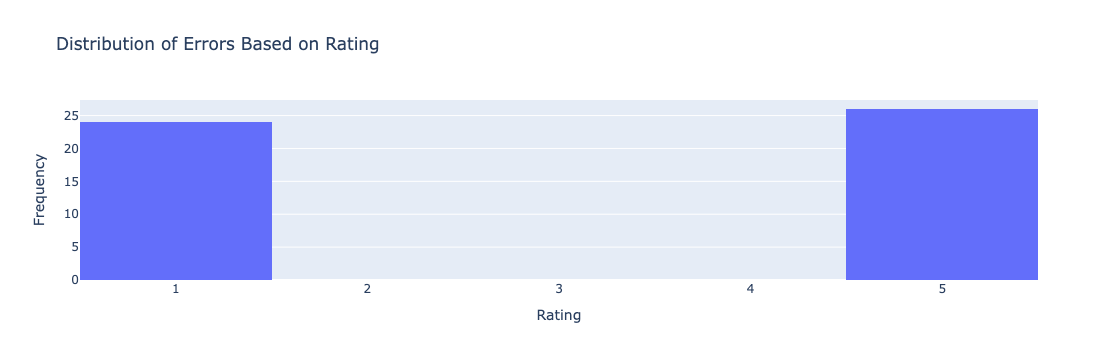

In [258]:
fig=px.histogram(top_errors['Rating'],x='Rating',nbins=5,title='Distribution of Errors Based on Rating')
fig.update_layout(xaxis_title='Rating',
                 yaxis_title='Frequency')

fig.show()


### Based on the error, we can see that SVD model predicts extreme ratings poorly (1 and 5)
#### it could be due to biases in the training data (e.g., fewer ratings of 1 or 5).  -- Implement bias correction or use a bias-aware matrix factorization model, which I checked the training data distribution which doesn't have data bias 
#### The model might overfit the training data, leading to poor generalization on extreme ratings (like 1 and 5).  ---Regularization

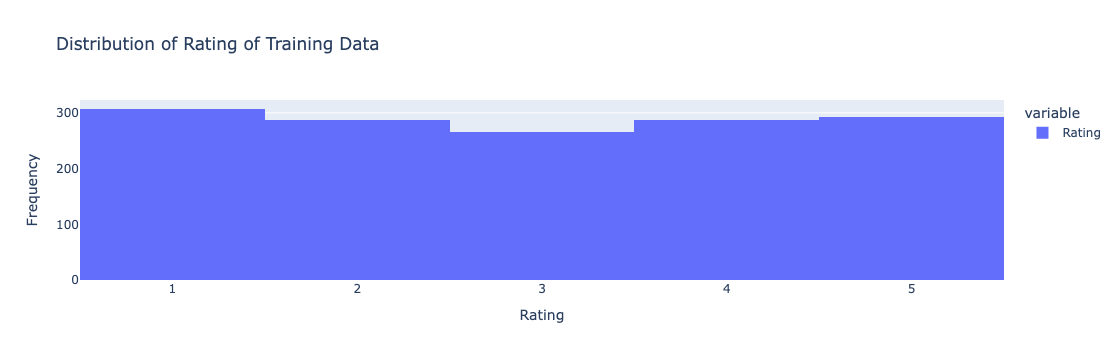

In [279]:
tmp=user_matrix_cleaned.merge(
    predictions_df,
    how='left',
    on=['User', 'Gift Idea']
)
fig=px.histogram(tmp.loc[tmp['SVD_Predictions'].isna(),'Rating'],title='Distribution of Rating of Training Data')
fig.update_layout(xaxis_title='Rating',
                 yaxis_title='Frequency')

In [295]:
# Define the model with regularization parameter
svd = SVD(reg_all=0.1)  # You can try different values for reg_all (e.g., 0.05, 0.2)

# Train the model
trainset = data.build_full_trainset()
svd.fit(trainset)

# Test the model
predictions = svd.test(testset)

svd_rmse=accuracy.rmse(predictions)

RMSE: 1.1355


In [321]:
joblib.dump(svd,'svd_model.pkl')

['svd_model.pkl']

In [ ]:
user_item_matrix=user_item_matrix.set_index('User')

In [509]:
def generate_nan_for_df(df):
    """
    This function is to generate random np.nan value in the original df
    """
    #Set the random seed for reproducibility
    np.random.seed(42)
    # Define the percentage of missing values you want to introduce (e.g., 20%)
    missing_percentage=0.2
    missing_num=int(np.floor(df.size*missing_percentage))
    #Get random indices where missing values will be introduced
    missing_indices=np.random.choice(df.size,num_missing,replace=False)
    # Convert the indices to row and column coordinates in the user-item matrix
    rows,cols=np.unravel_index(missing_indices,df.shape)
    # Now, correctly set the NaN values in the user-item matrix
    for row,col in zip(rows,cols):
        df.iloc[row,col]=np.nan
    return df

    

In [ ]:
user_item_matrix = generate_nan_for_df(user_item_matrix)

In [517]:
user_item_matrix.reset_index(inplace=True)

In [539]:
def recommend_gifts(user_id, model, df, top_n=5):
    """
    Recommend top N gifts for a specific user based on collaborative filtering.
    """
    # Get all gift ideas
    all_gifts = df.columns.tolist()
    
    # Gifts the user has already rated
    rated_gifts = user_item_matrix.loc[user_id].dropna().index.tolist()

    # Predict ratings for unrated gifts
    predictions = [
        (gift, model.predict(user_id, gift).est)
        for gift in all_gifts
        if gift not in rated_gifts
    ]

    # Sort by predicted ratings in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Return top N recommendations
    return pd.DataFrame(predictions[:top_n], columns=["Gift Idea", "Predicted Rating"])

In [545]:
# Example usage
user_id = 0
recommendations = recommend_gifts(user_id, svd, user_item_matrix, top_n=5)
print(recommendations)


                             Gift Idea  Predicted Rating
0            French Press Coffee Maker          3.459369
1  Nixplay Smart Digital Photo Frame.1          3.414728
2            Infantino Pop-Up Ball Pit          3.360619
3                     Luxury Spice Set          3.307940
4                   Galaxy Projector.1          3.233859


In [618]:
df_sorted.to_csv('df_sorted.csv',index=False)

In [606]:
def hybrid_recommendations(user_input, user_id, model, content_scores, top_n=5):
    """
    Combine content-based and collaborative filtering for hybrid recommendations.
    """
    collaborative_recs = recommend_gifts(user_id, model, user_item_matrix)
    collaborative_scores = collaborative_recs.set_index('Gift Idea')['Predicted Rating']

    # Merge collaborative scores with content-based scores
    combined_scores = content_scores.copy()
    combined_scores['Collaborative Score'] = combined_scores['Gift Idea'].map(collaborative_scores)
    combined_scores['Hybrid Score'] = 0.5 * combined_scores['similarity_score'] + 0.5 * combined_scores['Collaborative Score']
    
    # Sort by hybrid score
    combined_scores = combined_scores.sort_values(by='Hybrid Score', ascending=False)
    return combined_scores[['Gift Idea', 'Persona', 'Description', 'Hybrid Score']].head(top_n)


In [622]:
user_item_matrix.to_csv('updated_nan_user_item_matrix.csv',index=False)

In [628]:
%%writefile hybrid_app.py 
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load your precomputed embeddings and dataset
df_sorted= pd.read_csv('df_sorted.csv')
user_item_matrix = pd.read_csv('updated_nan_user_item_matrix.csv')



@st.cache_resource
def load_model():
    return joblib.load("svd_model.pkl")

svd = load_model()

def recommend_gifts(user_id, model, df, top_n=5):
    """
    Recommend top N gifts for a specific user based on collaborative filtering.
    """
    # Get all gift ideas
    all_gifts = df.columns.tolist()
    
    # Gifts the user has already rated
    rated_gifts = user_item_matrix.loc[user_id].dropna().index.tolist()

    # Predict ratings for unrated gifts
    predictions = [
        (gift, model.predict(user_id, gift).est)
        for gift in all_gifts
        if gift not in rated_gifts
    ]

    # Sort by predicted ratings in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Return top N recommendations
    return pd.DataFrame(predictions[:top_n], columns=["Gift Idea", "Predicted Rating"])

def hybrid_recommendations(user_input, user_id, model, content_scores, top_n=5):
    """
    Combine content-based and collaborative filtering for hybrid recommendations.
    """
    collaborative_recs = recommend_gifts(user_id, model, user_item_matrix)
    collaborative_scores = collaborative_recs.set_index('Gift Idea')['Predicted Rating']

    # Merge collaborative scores with content-based scores
    combined_scores = content_scores.copy()
    combined_scores['Collaborative Score'] = combined_scores['Gift Idea'].map(collaborative_scores)
    combined_scores['Hybrid Score'] = 0.5 * combined_scores['similarity_score'] + 0.5 * combined_scores['Collaborative Score']
    
    # Sort by hybrid score
    combined_scores = combined_scores.sort_values(by='Hybrid Score', ascending=False)
    return combined_scores[['Gift Idea', 'Persona', 'Description', 'Hybrid Score']].head(top_n)

# Get content-based scores
content_scores = df_sorted.copy()

user_input='2 year old toddler who loves animals'

# Example usage
hybrid_recs = hybrid_recommendations(user_input, 0, svd, content_scores, top_n=5)
st.write(hybrid_recs)

# Add User ID input

user_id = st.selectbox("Select a User ID", user_item_matrix.index.tolist())

# Add a button to generate recommendations
if st.button("Get Hybrid Recommendations"):
    hybrid_recs = hybrid_recommendations(user_input, user_id, svd, content_scores, top_n=5)
    st.write("Top Hybrid Recommendations:")
    st.write(hybrid_recs)



Overwriting hybrid_app.py
